# Object Detection (концепция)
---
Object detection = классификация + регрессия координат боксов.
YOLO делает:
- Разбивает изображение на сетку S×S.
- В каждой ячейке предсказывает:
  - вероятности классов
  - bounding box (x, y, w, h)
  - confidence score
  - NMS (Non-Max Suppression) убирает дубли.
Алгоритм:
- Backbone (CNN) — извлечение признаков
- Neck (FPN, PAN) — объединение признаков разных масштабов
- Head — предсказание боксов + классов
---


1. Суть задачи детекции
- Object Detection решает две проблемы одновременно:
  - Где объект? → регрессия координат bounding box
  - Что за объект? → классификация
- Выход модели = набор объектов, где каждый объект имеет:
  - координаты бокса:
    - (x_center, y_center, width, height)
  - confidence score — насколько модель уверена, что в боксе есть объект
  - class probability — вероятность каждого класса

2. - Backbone
Основная свёрточная сеть, извлекающая признаки.
- Типичные варианты:
  - ResNet
  - CSPDarknet
  - EfficientNet
  - MobileNet

Backbone получает чистое изображение → выводит feature maps.

2. - Neck
Объединяет признаки разных уровней масштабности.
Почему это нужно:
- маленькие объекты лучше видны на ранних слоях (большие карты признаков)
- большие объекты — на глубоких слоях
Основные конструкции:
- FPN (Feature Pyramid Network)
- PAN (Path Aggregation Network)
- BiFPN (EfficientDet)

2. - Detection Head
Последний слой, который предсказывает:
      - классы
      - objectness
      - bounding boxes
  - Два типа Head:
      - Anchor-based  Бокс предсказывается относительно заранее заданных anchor коробок  |
      - Anchor-free	  Модель сразу предсказывает координаты, без anchors                 |
---

Anchor-free проще, быстрее, точнее на маленьких объектах → поэтому YOLOv11 anchor-free.
1. Разметка данных

Типичная разметка для YOLO:
class_id x_center y_center width height
Все координаты — нормализованные от 0 до 1.

4. Как модель предсказывает боксы
Представим сетку 20×20.
Каждая клетка предсказывает:
- имеет ли объект (objectness score)
- координаты бокса (относительно клетки)
- вероятности классов
Формат выхода сети для каждой ячейки: [x, y, w, h, obj, class1, class2, ...]
Где:
  - (x, y) — сдвиг центра внутри клетки
  - (w, h) — ширина и высота
  - obj — вероятность, что бокс содержит объект
  - class probabilities — softmax или sigmoid

### МИНИ-ДЕТЕКТОР (TensorFlow): детекция объектов на игрушечном датасете
Сделаем минимальный SSD-style детектор на TensorFlow, который предсказывает один бокс.

In [5]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [7]:
# YOLOv11 пока нет официального TF Hub, используем аналог для демонстрации
yolo_model = tf.saved_model.load('https://tfhub.dev/tensorflow/yolov3/1')


UnimplementedError: File system scheme 'https' not implemented (file: 'https://tfhub.dev/tensorflow/yolov3/1/saved_model.pb')

In [ ]:
# Загрузка изображения
img_path = 'test.jpg'  # путь к вашему изображению
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Изменение размера под модель
input_size = 416
input_image = cv2.resize(image_rgb, (input_size, input_size))

# Нормализация
input_tensor = tf.convert_to_tensor(input_image[None, ...], dtype=tf.float32)/255.0


In [2]:
inputs = tf.keras.Input(shape=(64,64,1))

x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(3)(x)  # x, y, r

detector = tf.keras.Model(inputs, outputs)

detector.compile(optimizer='adam', loss='mse')
detector.summary()

detector.fit(X, Y, epochs=5, batch_size=32)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,067,651 (4.07 MB)

 Trainable params: 1,067,651 (4.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0080
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 2.1818e-04
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 8.7659e-05
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 4.0586e-05
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 2.7842e-05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


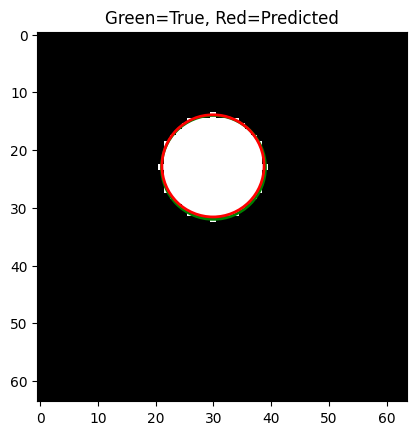

In [3]:
i = np.random.randint(len(X))
img = X[i]
true_box = Y[i]
pred_box = detector.predict(img[np.newaxis,...])[0]

plt.imshow(img.squeeze(), cmap='gray')

# функция рисования коробки
def draw_circle(x,y,r,color):
    circle = plt.Circle((x,y), r, fill=False, linewidth=2, color=color)
    plt.gca().add_patch(circle)

# true
draw_circle(true_box[0]*64, true_box[1]*64, true_box[2]*64, 'green')
# predicted
draw_circle(pred_box[0]*64, pred_box[1]*64, pred_box[2]*64, 'red')

plt.title("Green=True, Red=Predicted")
plt.show()


## YOLOv11 (краткий обзор)
YOLOv11 — модель Ultralytics 2024+, улучшенная версия v8/v10.
Главные элементы:
- Backbone: CSPDarknet-like
- Neck: FPN+PAN
- Head: Task-Aligned
- Простое API (pip install ultralytics)
- YOLOv11 → PyTorch, TensorFlow-версии нет.
---
---

SyntaxError: invalid character '—' (U+2014) (630393715.py, line 2)